## Import necessary library

In [1]:
%matplotlib inline

In [2]:
import os

import pandas as pd
import numpy as np

from eugene import settings, train, models, interpret, evaluate

from eugene import plot as pl
from eugene import preprocess as pp

import glob
import seqdatasets

from data_utils import TransformerModel


/home/raymondlab/anaconda3/envs/BME/lib/python3.9/site-packages/numba/np/ufunc/parallel.py:371: NumbaWarning: The TBB threading layer requires TBB version 2021 update 6 or later i.e., TBB_INTERFACE_VERSION >= 12060. Found TBB_INTERFACE_VERSION = 12050. The TBB threading layer is disabled.
  warnings.warn(problem)
/home/raymondlab/anaconda3/envs/BME/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Config settings

In [3]:
settings.config_dir = "./configs"
settings.dataset_dir = "./dataset"
settings.logging_dir = "./logs"
settings.output_dir = "./output"
settings.figure_dir = "./figures"

### I will test with jores21() 
I tried with MPRA data, it takes forever to load - maybe simply using dataloader would be slower...

In [4]:
sdata_jores = seqdatasets.jores21()

Dataset jores21 CNN_test_leaf.tsv has already been downloaded.
Dataset jores21 CNN_train_leaf.tsv has already been downloaded.
Zarr file found. Opening zarr file.


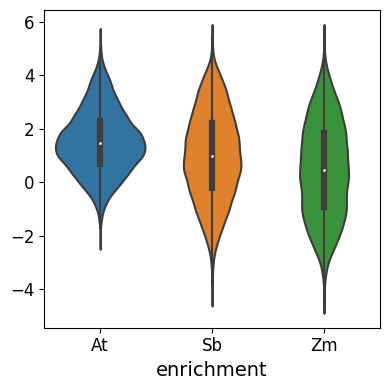

In [5]:
pl.violinplot(sdata_jores, vars=["enrichment"], groupby="sp", figsize=(4, 4))

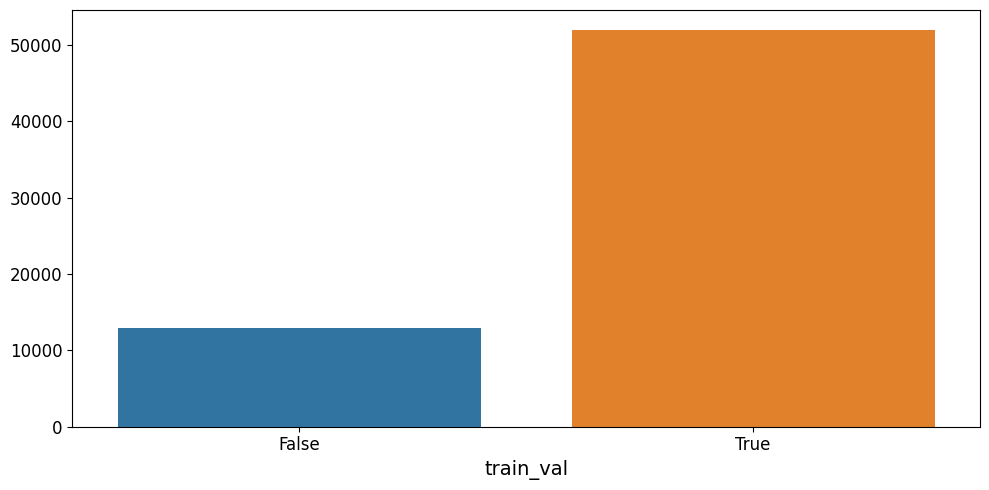

In [6]:
pp.ohe_seqs_sdata(sdata_jores, alphabet="DNA")
pp.make_unique_ids_sdata(sdata_jores)

sdata_jores_train = sdata_jores.sel(_sequence=(sdata_jores["set"] == "train").compute())
sdata_jores_test = sdata_jores.sel(_sequence=(sdata_jores["set"] == "test").compute())

pp.train_test_random_split(sdata_jores_train, dim="_sequence", train_var="train_val", test_size=0.2)
pl.countplot(sdata_jores_train, vars="train_val", orient="h")

### Model import via Sequence Module in EUGENe

In [7]:
model = models.SequenceModule(
    arch=TransformerModel(d_model=64),
    task="regression",
    loss_fxn="mse",
    optimizer="adam",scheduler="reduce_lr_on_plateau"
)

/home/raymondlab/anaconda3/envs/BME/lib/python3.9/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


In [8]:
models.init_weights(model,initializer="xavier_uniform")

In [9]:
train.fit_sequence_module(
    model=model,
    sdata=sdata_jores_train,
    seq_var="ohe_seq",
    target_vars=["enrichment"],
    in_memory=True,
    train_var="train_val",
    epochs=30,
    batch_size=128,
    num_workers=4,
    prefetch_factor=2,
    early_stopping_patience=25,
    drop_last=False,
    name="TransformerModel",
    version="jores21",
    transforms={"ohe_seq": lambda x: x.swapaxes(1, 2)}
)



GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 4080') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
/home/raymondlab/anaconda3/envs/BME/lib/python3.9/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/raymondlab/Documents/BME/mini_project1/logs/TransformerModel/jores21/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type             | Params | Mode 
----------------------------------------------------------
0 | arch         | TransformerModel | 204 K  | train
1 | train_metric | R2Score          | 0      | train
2 | val_m

Dropping 0 sequences with NaN targets.
Loading ohe_seq and ['enrichment'] into memory
No seed set
Epoch 29: 100%|██████████| 407/407 [00:18<00:00, 21.75it/s, v_num=es21, train_loss=0.578, val_r2score_epoch=0.683]

`Trainer.fit` stopped: `max_epochs=30` reached.


Epoch 29: 100%|██████████| 407/407 [00:18<00:00, 21.75it/s, v_num=es21, train_loss=0.578, val_r2score_epoch=0.683]


### Unlike other models such as CNN, or hybrid that classmates have uploaded in teams, the model is not overfitting as train and valid sets are showing similar R2 results.

/home/raymondlab/anaconda3/envs/BME/lib/python3.9/site-packages/eugene/plot/_utils.py:321: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_logs = all_logs.append(log, ignore_index=True)
/home/raymondlab/anaconda3/envs/BME/lib/python3.9/site-packages/eugene/plot/_utils.py:321: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_logs = all_logs.append(log, ignore_index=True)


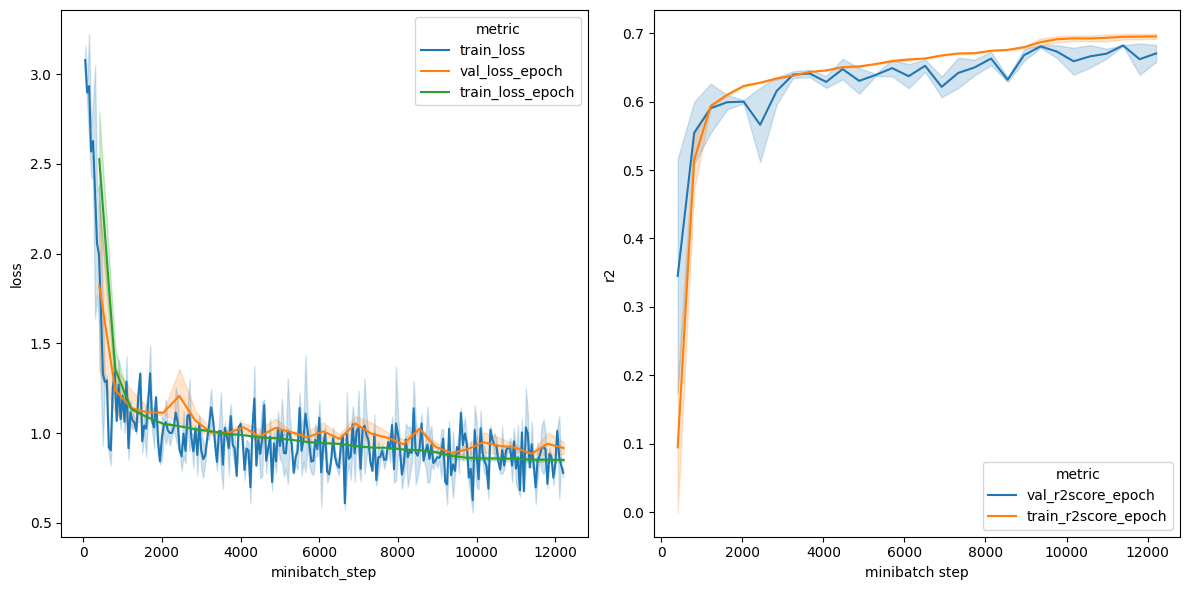

In [10]:
pl.training_summary(os.path.join(settings.logging_dir, "TransformerModel", "jores21"), metric="r2")

In [11]:
model_file = glob.glob(os.path.join(settings.logging_dir, "TransformerModel", "jores21", "checkpoints", "*"))[0]
best_model = models.SequenceModule.load_from_checkpoint(model_file, arch=model.arch)

In [12]:
evaluate.predictions_sequence_module(
    best_model,
    sdata=sdata_jores_test,
    seq_var="ohe_seq",
    target_vars="enrichment",
    batch_size=128,
    in_memory=True,
    name="TransformerModel",
    version="jores21",
    file_label="test",
    prefix=f"jores21_",
    transforms={"ohe_seq": lambda x: x.swapaxes(1, 2)}
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/raymondlab/anaconda3/envs/BME/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Loading ohe_seq and ['enrichment'] into memory
Predicting DataLoader 0: 100%|██████████| 56/56 [00:00<00:00, 141.26it/s]


### MSE loss looks good; compared to DeepSTARR models, it is little higher, and R2 is lower. I observed that there is a threshold on the top and bottom of enrichment scores for prediction in Transformer models. Maybe once this is resolved, it can outperform DeepSTARR.

#### I tried to simplify final layer, hidden layer, input layer, and etc... same results. tried to change activations, same results. tried different init_weights methods. same results. CLS tokens to random - same results...

Dropping 0 sequences with NaN targets.
Group R2 MSE Pearsonr Spearmanr
At 0.5184847555646263 0.6706714349853036 0.7082330240173887
Sb 0.6813926501597005 0.8650246587218654 0.8373352444719844
Zm 0.6973637607455434 0.9214809313827975 0.8383764979379544


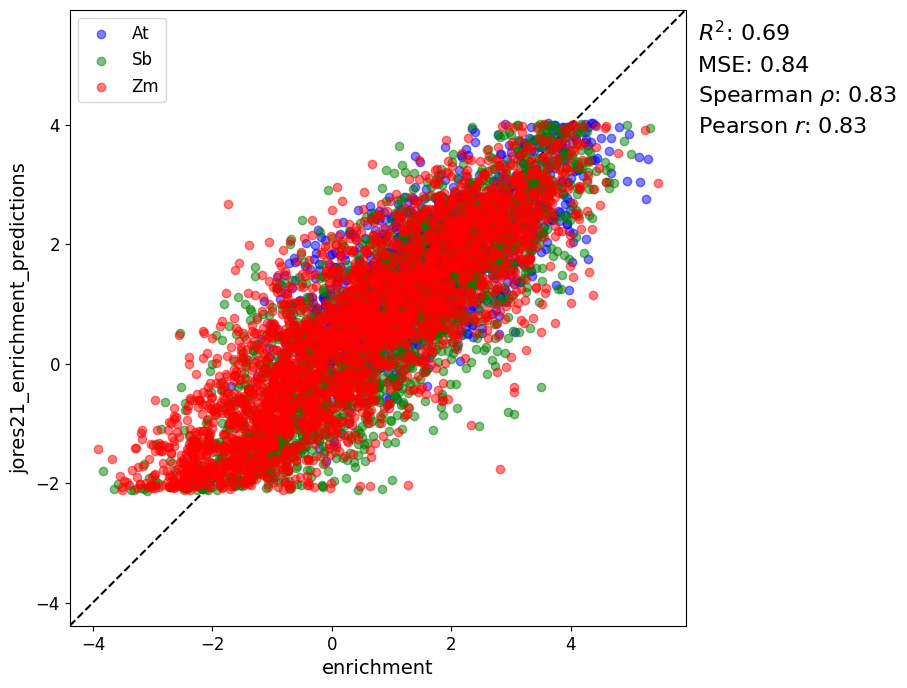

In [13]:
pl.performance_scatter(
    sdata_jores_test,
    target_vars="enrichment",
    prediction_vars="jores21_enrichment_predictions",
    alpha=0.5,
    groupby="sp",
    figsize=(8, 8)
)

In [14]:
model.summary()

Model: TransformerModel
Sequence length: 170
Output dimension: 1
Task: regression
Loss function: mse_loss
Optimizer: Adam
	Optimizer parameters: {}
	Optimizer starting learning rate: 0.001
Scheduler: ReduceLROnPlateau
	Scheduler parameters: {}
Metric: r2score
	Metric parameters: {}
Seed: None
Parameters summary:


  | Name         | Type             | Params | Mode 
----------------------------------------------------------
0 | arch         | TransformerModel | 204 K  | train
1 | train_metric | R2Score          | 0      | train
2 | val_metric   | R2Score          | 0      | train
3 | test_metric  | R2Score          | 0      | train
----------------------------------------------------------
204 K     Trainable params
0         Non-trainable params
204 K     Total params
0.817     Total estimated model params size (MB)
75        Modules in train mode
0         Modules in eval mode

In [15]:
model_check = TransformerModel()
model_check

/home/raymondlab/anaconda3/envs/BME/lib/python3.9/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


TransformerModel(
  (feature_extraction): Sequential(
    (0): Conv1d(4, 16, kernel_size=(13,), stride=(1,), padding=(6,))
    (1): LeakyReLU(negative_slope=0.2)
    (2): Conv1d(16, 32, kernel_size=(7,), stride=(1,), padding=(3,))
    (3): LeakyReLU(negative_slope=0.2)
  )
  (embedding): Sequential(
    (0): Linear(in_features=32, out_features=64, bias=True)
    (1): Dropout(p=0.2, inplace=False)
    (2): LeakyReLU(negative_slope=0.2)
  )
  (pos_encoder): PositionalEncoding(
    (dropout): Dropout(p=0.2, inplace=False)
  )
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-3): 4 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=64, out_features=64, bias=True)
        )
        (linear1): Linear(in_features=64, out_features=160, bias=True)
        (dropout): Dropout(p=0.2, inplace=False)
        (linear2): Linear(in_features=160, out_features=64, bias=True)
        (norm1): L

### Could be interesting to see the Attention layers, but EUGENe does not seem to have a visualization methods...

In [16]:
model_check = TransformerModel()
for name, module in model_check.named_modules():
    print(name)


feature_extraction
feature_extraction.0
feature_extraction.1
feature_extraction.2
feature_extraction.3
embedding
embedding.0
embedding.1
embedding.2
pos_encoder
pos_encoder.dropout
transformer_encoder
transformer_encoder.layers
transformer_encoder.layers.0
transformer_encoder.layers.0.self_attn
transformer_encoder.layers.0.self_attn.out_proj
transformer_encoder.layers.0.linear1
transformer_encoder.layers.0.dropout
transformer_encoder.layers.0.linear2
transformer_encoder.layers.0.norm1
transformer_encoder.layers.0.norm2
transformer_encoder.layers.0.dropout1
transformer_encoder.layers.0.dropout2
transformer_encoder.layers.1
transformer_encoder.layers.1.self_attn
transformer_encoder.layers.1.self_attn.out_proj
transformer_encoder.layers.1.linear1
transformer_encoder.layers.1.dropout
transformer_encoder.layers.1.linear2
transformer_encoder.layers.1.norm1
transformer_encoder.layers.1.norm2
transformer_encoder.layers.1.dropout1
transformer_encoder.layers.1.dropout2
transformer_encoder.layer

In [17]:
from eugene import interpret

In [18]:
interpret.generate_pfms_sdata(
    best_model,
    sdata_jores_test,
    seq_var="ohe_seq",
    layer_name="arch.feature_extraction.0",
    kernel_size=13,
    num_filters=16,
    num_seqlets=100,
    transforms={"ohe_seq": lambda x: x.swapaxes(1, 2)}
)

Getting activations on batches of size 128:  20%|█▉        | 11/56 [00:00<00:00, 102.65it/s]

Getting filter activators for 16 filters: 100%|██████████| 16/16 [00:01<00:00, 10.77it/s]


### Like other methods, CpG island and TATA box are the most observed one. in 13 kernels filters.

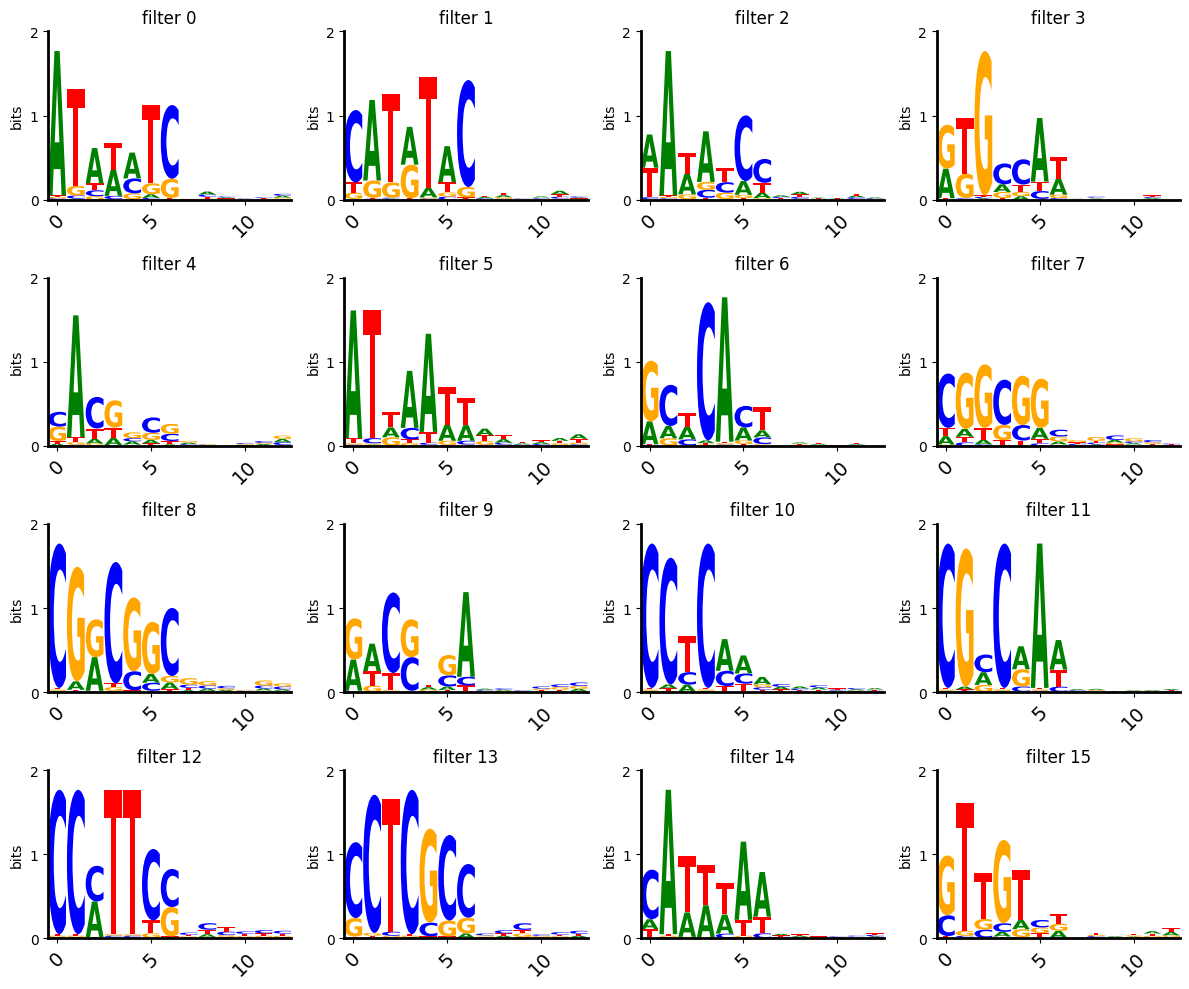

In [19]:
pl.multifilter_viz(
    sdata_jores_test,
    filter_nums=range(0, 16),
    pfms_var="arch.feature_extraction.0_pfms",
    num_rows=4,
    num_cols=4,
    titles=[f"filter {i}" for i in range(0, 16)],
)


### You can see more clearly in second conv layers. kernel size 7.


In [20]:
interpret.generate_pfms_sdata(
    best_model,
    sdata_jores_test,
    seq_var="ohe_seq",
    layer_name="arch.feature_extraction.3",
    kernel_size=7,
    num_filters=32,
    num_seqlets=100,
    transforms={"ohe_seq": lambda x: x.swapaxes(1, 2)}
)

Getting filter activators for 32 filters: 100%|██████████| 32/32 [00:02<00:00, 10.96it/s]


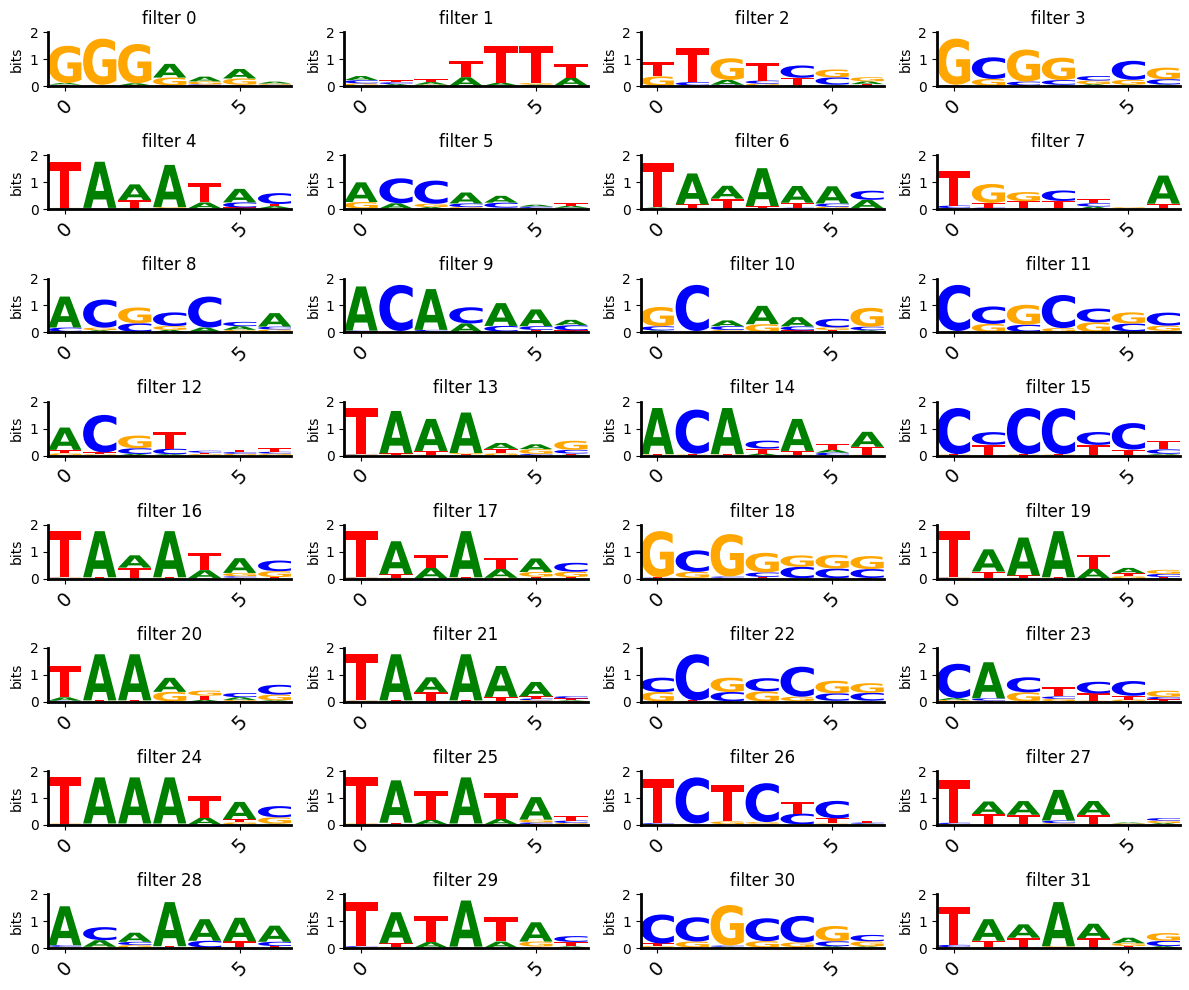

In [21]:
pl.multifilter_viz(
    sdata_jores_test,
    filter_nums=range(0, 32),
    pfms_var="arch.feature_extraction.3_pfms",
    num_rows=8,
    num_cols=4,
    titles=[f"filter {i}" for i in range(0, 32)],
)


In [22]:
interpret.attribute_sdata(
    best_model,
    sdata_jores_test,
    batch_size=128,
    reference_type="zero",
    transforms={"ohe_seq": lambda x: x.swapaxes(1, 2)}
)



Computing saliency on batches of size 128:   0%|          | 0/56 [00:00<?, ?it/s]/home/raymondlab/anaconda3/envs/BME/lib/python3.9/site-packages/seqexplainer/attributions/_attributions.py:119: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs_ = torch.tensor(inputs_, dtype=torch.float32).requires_grad_(True).to(device)
Computing saliency on batches of size 128: 100%|██████████| 56/56 [00:01<00:00, 33.09it/s]


Importance values:   0%|          | 0/1 [00:00<?, ?it/s]

Importance values: 100%|██████████| 1/1 [00:01<00:00,  1.64s/it]


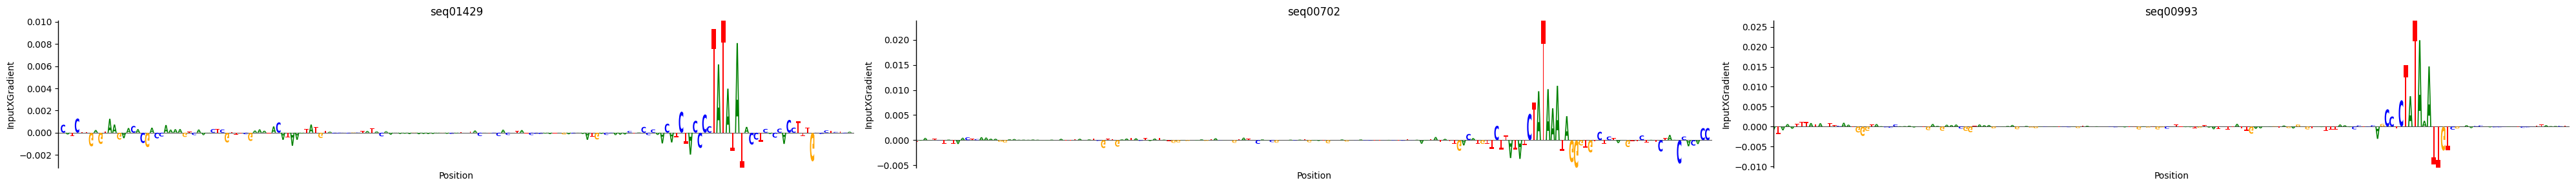

In [24]:
top3 = sdata_jores_test["jores21_enrichment_predictions"].to_series().sort_values(ascending=False).iloc[:3].index
ids = sdata_jores_test["id"].values[top3]
pl.multiseq_track(
    sdata_jores_test,
    seq_ids=ids,
    attrs_vars = "InputXGradient_attrs",
    ylabs="InputXGradient",
    height=3,
    width=40,
)